In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import VAR
import yfinance as yf
from matplotlib import dates as dt
from numpy import linalg
from scipy.stats import binom
import matplotlib.ticker as ticker
import matplotlib as mpl

# Sentiment Data

In [42]:
df_sentiment = pd.read_csv("../data/sentiment_daily_data.csv")
df_sentiment.index = pd.DatetimeIndex(df_sentiment["release_date"]).to_period("D")
df_sentiment = df_sentiment.drop('release_date', axis = 1)
df_sentiment

,AAPL_daily,AAPL_diff,AMZN_daily,AMZN_diff,BAC_daily,BAC_diff,CVX_daily,CVX_diff,HD_daily,HD_diff,...,PFE_daily,PFE_diff,PG_daily,PG_diff,TSLA_daily,TSLA_diff,WMT_daily,WMT_diff,XOM_daily,XOM_diff
release_date,,,,,,,,,,,,,,,,,,,,,
2014-01-04,0.9747,-0.9876,0.9870,0.0,1.8862,0.0000,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9595,0.0000
2014-01-05,2.6382,1.6635,0.9870,0.0,0.9956,-0.8906,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9977,0.0382
2014-01-06,2.6382,0.0000,0.9870,0.0,0.9956,0.0000,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,-0.0010
2014-01-07,-0.2695,-2.9077,0.9870,0.0,2.9495,1.9539,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,0.0000
2014-01-08,-0.2695,0.0000,0.9870,0.0,0.9862,-1.9633,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-09,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,1.9594,0.7939,0.9975,0.0,...,1.9891,0.0000,-0.9581,0.0,20.7979,0.0,0.3612,-0.6384,-0.9922,0.0000
2020-02-10,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,1.9594,0.0000,0.9975,0.0,...,1.9891,0.0000,-0.9581,0.0,20.7979,0.0,0.3612,0.0000,-0.5306,0.4616
2020-02-11,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,0.0732,-1.8862,0.9975,0.0,...,1.5383,-0.4508,-0.9581,0.0,20.7979,0.0,0.3612,0.0000,1.9926,2.5232


# Stock Data

In [43]:
df_prices = pd.read_csv("../data/stock_data_daily_pct_change.csv")
df_prices.index = pd.DatetimeIndex(df_prices["Date"]).to_period("D")
df_prices = df_prices.drop('Date', axis = 1)
df_prices = df_prices.drop("Date.1", axis = 1)

# Drop columns with little amount of data (determined in "Sentiment Analysis.ipynb")
df_prices = df_prices.drop(["LLY", "NVDA", "MA", "UNH", "V"], axis = 1)
df_prices

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE
Date,,,,,,,,,,,,,,,
2011-01-04,0.005219,0.003931,0.003524,0.004288,0.001878,0.004695,0.014473,-0.020699,0.003849,-0.003698,0.008437,-0.018125,0.002779,0.008602,0.017534
2011-01-05,0.008180,-0.003204,0.018258,0.013026,0.005999,-0.002670,0.012229,-0.005950,-0.006573,-0.001747,-0.000631,-0.003172,-0.002310,0.005777,0.006671
2011-01-06,-0.000808,0.029286,-0.004138,-0.008324,0.039135,0.006426,-0.004922,-0.007245,-0.008270,-0.008202,-0.001580,-0.004051,-0.001698,0.013676,0.003865
2011-01-07,0.007161,-0.007634,-0.013158,-0.001991,0.012912,0.005453,-0.018885,-0.001745,0.002224,0.005514,-0.009650,-0.001162,-0.002937,0.007825,0.008801
2011-01-10,0.018833,-0.013287,0.010526,-0.004367,0.007436,-0.006086,-0.005500,0.002225,-0.006472,-0.008554,-0.007029,0.000291,-0.002171,-0.004016,-0.004362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.016319,0.000000,0.006007,0.003638,0.033605,0.005004,-0.000292,-0.001092,-0.010475,0.005431,0.002602,-0.008952,-0.003670,0.001747,0.002294
2019-12-24,0.000951,-0.000191,0.001422,-0.002114,0.014384,-0.003842,0.002770,-0.003642,0.004033,0.000083,-0.003483,0.006660,0.002562,-0.003270,-0.000763
2019-12-26,0.019840,0.008197,0.008518,0.044467,0.013380,0.001571,0.010612,0.005666,0.000084,0.002160,-0.000685,0.000680,0.000000,-0.001093,0.002291


# VAR model of merge


In [44]:
def var_model(df_sentiment: pd.DataFrame, df_prices: pd.DataFrame)-> tuple[VAR, pd.DataFrame]:
    """
    Make a VAR model for a specific stock

    Returns a tuple of the VAR model and a merged dataframe consisting of the prices and
    the sentiment.
    """
    merged_df = pd.merge(df_prices, df_sentiment, left_index= True, right_index = True)
    new_names = {df_sentiment.name: f"{df_prices.name}_sentiment", df_prices.name: f"{df_prices.name}_prices"}
    merged_df = merged_df.rename(new_names, axis=1)
    return VAR(merged_df), merged_df

In [45]:
var_models = []
merged_dfs = []
for ticker in df_prices.columns:
    var, merged_df = var_model(df_sentiment[f"{ticker}_diff"], df_prices[ticker])
    var_models.append(var)
    merged_dfs.append(merged_df)

In [46]:
results = []
for model in var_models:
    result = model.fit(maxlags=35, ic='aic')
    results.append(result)
    print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 24, Dec, 2022
Time:                     22:31:56
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.27623
Nobs:                     1492.00    HQIC:                  -3.39675
Log likelihood:          -1592.73    FPE:                  0.0311691
AIC:                     -3.46833    Det(Omega_mle):       0.0300709
--------------------------------------------------------------------
Results for equation AAPL_prices
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.001052         0.000412            2.556           0.011
L1.AAPL_prices             0.018722         0.026095            0.717           0.473
L1.AAPL_sentiment         -0.00001

# Testing asssumptions

### Assumption 1
The mean of the residuals should be approximately zero:

In [47]:
for result in results:
    sentiment = result.names[0]
    price = result.names[1]
    print(f"{sentiment} resid. mean = ",result.resid[sentiment].mean())
    print(f"{price} resid. mean = ", result.resid[price].mean())

AAPL_prices resid. mean =  -3.7205865436499885e-20
AAPL_sentiment resid. mean =  -1.2191617986232282e-15
MSFT_prices resid. mean =  -7.083357108085284e-19
MSFT_sentiment resid. mean =  -6.012651759957866e-16
BAC_prices resid. mean =  -1.1109636670698698e-18
BAC_sentiment resid. mean =  -2.3700558230823888e-17
AMZN_prices resid. mean =  3.154042683594195e-19
AMZN_sentiment resid. mean =  -7.409402859530457e-16
TSLA_prices resid. mean =  -7.396555793638618e-19
TSLA_sentiment resid. mean =  -1.8935182831714862e-17
XOM_prices resid. mean =  9.899488636240979e-19
XOM_sentiment resid. mean =  1.5631940186722203e-16
JPM_prices resid. mean =  2.0340528432506198e-19
JPM_sentiment resid. mean =  9.467591415857431e-18
KO_prices resid. mean =  -8.157951416751317e-19
KO_sentiment resid. mean =  -3.9158166800406325e-17
WMT_prices resid. mean =  1.3322676295501879e-18
WMT_sentiment resid. mean =  9.592326932761352e-17
CVX_prices resid. mean =  -8.91148916087082e-19
CVX_sentiment resid. mean =  -7.604

### Assumption 2

Covariance matrix of the errors should be positive semi definite, so the eigenvalues should be positive and the matrix symetric

In [48]:
for result in results:
    cov_matrix = result.resid_corr
    print(cov_matrix.shape)
    print(linalg.eigvals(cov_matrix))

(2, 2)
[1.04662188 0.95337812]
(2, 2)
[1.00788712 0.99211288]
(2, 2)
[0.92905974 1.07094026]
(2, 2)
[0.94624465 1.05375535]
(2, 2)
[1.03531543 0.96468457]
(2, 2)
[0.95911783 1.04088217]
(2, 2)
[1.00378321 0.99621679]
(2, 2)
[0.98846532 1.01153468]
(2, 2)
[1.09339304 0.90660696]
(2, 2)
[0.98085952 1.01914048]
(2, 2)
[1.03034024 0.96965976]
(2, 2)
[1.07884307 0.92115693]
(2, 2)
[1.03233171 0.96766829]
(2, 2)
[1.00850229 0.99149771]
(2, 2)
[1.06631872 0.93368128]


### Assumption 3

Residuals should have no residual auto correlation:

In [49]:
for result in results:
    print(f"{result.names[0]} and {result.names[1]}:")
    print(result.test_whiteness(result.k_ar+1).summary(), "\n \n")

AAPL_prices and AAPL_sentiment:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 14 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.813          9.488   0.590  4
---------------------------------------- 
 

MSFT_prices and MSFT_sentiment:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 17 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.042          9.488   0.060  4
---------------------------------------- 
 

BAC_prices and BAC_sentiment:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 7 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.642       

### Assumption 4

Data should be normally distributed:

In [50]:
for result in results:
    print(result.test_whiteness(result.k_ar+1).summary())
    # print(str(result.test_normality()))

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 14 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.813          9.488   0.590  4
----------------------------------------
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 17 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.042          9.488   0.060  4
----------------------------------------
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 7 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.642          9.488   0.619  4
----------------------------------------
Portmanteau-test for residual autocorrela

Visualizing results in a Matrix:



In [51]:
def normallity_of_residuals(result) -> bool:
    '''This function tests the normality of residuals, given these residuals and returns the p value. Test using significance of alpha = 0.05'''
    p_value = pd.DataFrame(result.test_normality().summary().data).iloc[1,2]
    if p_value < 0.05:
            significant_p = True
    else:
            significant_p = False
    return significant_p

In [52]:
def autocorrelation_of_residuals(result) -> bool:
    '''This function tests the autocOrrelation of residuals, given these residuals and returns the p vavlues'''
    p_value = pd.DataFrame(result.test_whiteness(result.k_ar+1).summary().data).iloc[1,2]
    if p_value < 0.05:
            significant_p = True
    else:
            significant_p = False
    return significant_p

In [53]:
def check_mean_of_residuals(result) -> tuple:
      '''checking if residuals of a VAR results containing the residuals of 2 respective timeseries have mean 0 and returns a tuple containing boolean values
       #  ref: https://en.wikipedia.org/wiki/Vector_autoregression '''
      sentiment = result.names[0]
      price = result.names[1]
      if result.resid[sentiment].mean() < 0.001:
            sentiment_timeseries_residual_mean_of_0 = True
      if result.resid[price].mean() < 0.001:
            price_timeseries_residual_mean_of_0 = True
      if sentiment_timeseries_residual_mean_of_0 and price_timeseries_residual_mean_of_0:
            return True
      else:
            return False


In [54]:
def matrix_is_postivive_and_semidefinite(matrix) -> bool:
    """ checking if covariance matrix is positive and semi-definite. This can be checked by checking of the matrix is symetric and eigenvalues are positive. 
    ref: https://en.wikipedia.org/wiki/Definite_matrix"""
    cov_matrix = result.resid_corr
    cov_matrix = result.resid_corr
    is_symmetric = cov_matrix.shape[0] == cov_matrix.shape[1]
    eigen_values = linalg.eigvals(cov_matrix)
    eigen_values_positive = eigen_values[0]> 0 and eigen_values[1] > 0 
    if is_symmetric and eigen_values_positive:
        covariance_matrix_positive_and_semi_definite = True
    else:
        covariance_matrix_positive_and_semi_definite = False
    return covariance_matrix_positive_and_semi_definite

In [55]:
def Assumption_matrix(List_of_results: list) -> pd.DataFrame:
    '''Creates a dataframe of assumption test results per stock, where true is the value if the assumption passes and False when it does not'''
    dict_of_assumption_test_results_per_stock = {}
    for result in results:
        stock_name = result.names[0]
        dict_of_assumption_test_results = {str(stock_name):{'Mean of residuals = 0':check_mean_of_residuals(result), 'Autocorrelation of residuals = 0': autocorrelation_of_residuals(result), 'Covariance Matrix positive and semidefinite':matrix_is_postivive_and_semidefinite(result), 'normality of residuals':normallity_of_residuals(result)}}
        dict_of_assumption_test_results_per_stock.update(dict_of_assumption_test_results)
    df_of_assumption_test_results = pd.DataFrame(dict_of_assumption_test_results_per_stock)
    return df_of_assumption_test_results

In [124]:
def plot_assumptions_all_stocks(matrix):
    """Plot the assumption matrix for all stocks"""
    len_matrix = len(matrix.columns)
    colnames = []
    for col in matrix.columns:
        colnames.append(col[:-7])
    fig, ax = plt.subplots(1,1)
    ax.set_xticklabels(colnames, rotation=90)
    cmap = (mpl.colors.ListedColormap(['red', 'green']))
    ax.imshow(matrix, cmap=cmap)
    ax.set_yticks(range(4))
    ax.set_xticks(range(len_matrix))
    ax.set_yticklabels([
        "Error mean = 0",
        "Residual Autocorrelation = 0",
        "Covariance matrix positive and semi definite",
        "Normality of residual"
        ])
    plt.xlabel("window")
    plt.ylabel("test")
    plt.title(f"Assumption tests for all stocks (whole period)")
    plt.show()

In [126]:
Assumption_matrix(results)

,AAPL_prices,MSFT_prices,BAC_prices,AMZN_prices,TSLA_prices,XOM_prices,JPM_prices,KO_prices,WMT_prices,CVX_prices,JNJ_prices,HD_prices,PG_prices,MRK_prices,PFE_prices
Mean of residuals = 0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Autocorrelation of residuals = 0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
Covariance Matrix positive and semidefinite,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
normality of residuals,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


C:\Users\Nitai Nijholt\AppData\Local\Temp\ipykernel_33392\1966614927.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(colnames, rotation=90)


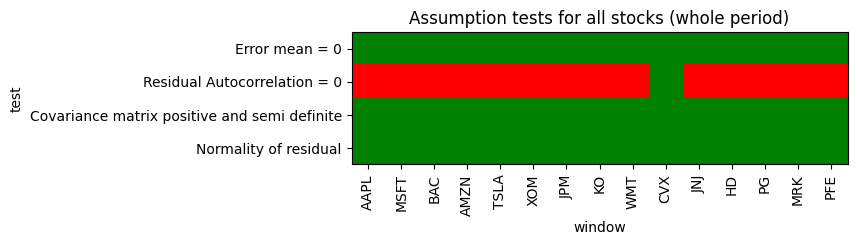

In [125]:
plot_assumptions_all_stocks(Assumption_matrix(results))

# Summary of Results per stock

In [59]:
for result in results:
    print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 24, Dec, 2022
Time:                     22:32:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.27623
Nobs:                     1492.00    HQIC:                  -3.39675
Log likelihood:          -1592.73    FPE:                  0.0311691
AIC:                     -3.46833    Det(Omega_mle):       0.0300709
--------------------------------------------------------------------
Results for equation AAPL_prices
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.001052         0.000412            2.556           0.011
L1.AAPL_prices             0.018722         0.026095            0.717           0.473
L1.AAPL_sentiment         -0.00001

We can ofcourse interpret the significance for the coefficients for individual stock. For the apple stock, only showing signficant coefficients at alpha = 0.05.

This would result in the following formula for the VAR model:

$y_{1t} = c1 + \beta{11,8} y{1,t-8} + \beta{12,13} y{2,t-13}+ \epsilon{1,t}$ 

$y_{2t} = c2 + \beta{22,1} y{2,t-1} + \beta{22,2} y{2,t-2} + \beta{22,3} y{2,t-3} + \beta{22,4} y{2,t-4} + \beta{22,5} y{2,t-5} + \beta{22,6} y{2,t-6} + \beta{22,7} y{2,t-7} + \beta{21,8} y{1,t-8} + \beta{22,8} y{2,t-8} + \beta{22,9} y{2,t-9} + \beta{22,10} y{2,t-10} + \beta{22,11} y{2,t-11} + \beta{22,12} y{2,t-12} + \beta{22,13} y{2,t-13} + \epsilon{2,t}$ 

where y_{1t} is the price timeseries and y_{2t} is the sentiment timeseries, 
\beta{r,i} being the coefficient belonging to the price coefficient of the i'th lag in the first equation, \beta{2j} being the coefficient belonging to the price coefficient of the j'th lag.

However, we are interested in the amount of significant coefficients across all stocks

In [61]:
def significant_coefficients_per_stock(results: list, predictor:int)-> dict:
    """"creates a DataFrame with significant coefficient count of either the 'sentiment' or 'price' coefficients in the price timeseries, given a list of VAR results objects
     input 0 for 'sentiment' or 1 for 'price' as predictor, to select the regressor of interest)"""
    if predictor == 0:
        # select sentiment as predictor variable
        predictor = '_sentiment'
        slice = -10
        # select price as response variable
        response = 0
    elif predictor == 1:
        # select price as predictor variable
        predictor = '_prices'
        slice = -7
        # select sentiment as response variable
        response = 1
    else:
        print('please input 0 for sentiment or 1 for price')
    
    dict_of_all_stock_coeff_results = {}
    list_of_names = []
    dict_of_coeff_results  = {}
    for result in results:
        p_values_df = result.pvalues
        significant_p = p_values_df.iloc[:,:] < 0.05
        # Create an empty list to store the rows that should be kept
        to_keep = []

        # Loop over the rows of the DataFrame
        for index, row in p_values_df[significant_p].iterrows():
            # Check if all elements in the row are null
            if row.isnull().all():
                # If any elements are null, skip this row
                continue
            # If any elements are non-null, append the index to the list of rows to keep
            to_keep.append(index)

        # Use the list of rows to keep to filter the DataFrame
        filtered_df_onestock = p_values_df[significant_p].loc[to_keep]
        indices_of_chosen_variables = []
        # make a list containing the indices of the chosen predictor variables only
        index = filtered_df_onestock.iloc[:,response].index
        for item in index:
            try:
                if item[slice:] ==predictor:
                    indices_of_chosen_variables.append(item)
            except:
                continue
        # select only the 'price' column (as this is the response variable we are interested in) and select only the rows which are the regressors either 'sentiment'or 'price' rows
        rows_selected = filtered_df_onestock.iloc[:,response].loc[indices_of_chosen_variables]
        # counting the non missing (significant) predictor coefficients
        try:
            count = rows_selected.isna().value_counts()[False]
        # excepting away the key error in the case where there are no (significant)  coefficients
        except:
            count = 0
        # create a dict of dicts with significant coefficient count and lag order as inner dict and stock ticker symbol as outer dict
        dict_of_all_stock_coeff_results[result.names[1][:-10]] = {f'significant {str(predictor[1:])} coefficient count, alpha = 0.05' : count,' lag order ': result.k_ar}
    # convert dict of dicts to dataframe 
    df_significant_coeffs_VAR = pd.DataFrame.from_dict(dict_of_all_stock_coeff_results, orient='index')
    return df_significant_coeffs_VAR

In [62]:
significant_coefficients_per_stock(results, 0)

,"significant sentiment coefficient count, alpha = 0.05",lag order
AAPL,1,13
MSFT,2,16
BAC,3,6
AMZN,1,9
TSLA,0,4
XOM,1,5
JPM,0,4
KO,0,8
WMT,1,5
CVX,3,10


In [63]:
significant_coefficients_per_stock(results, 1)

,"significant prices coefficient count, alpha = 0.05",lag order
AAPL,1,13
MSFT,0,16
BAC,0,6
AMZN,1,9
TSLA,1,4
XOM,0,5
JPM,1,4
KO,1,8
WMT,0,5
CVX,1,10


# Hypothesis testing



## Main hypothesis:

## H0 A: There is no relationship between sentiment about a stock in news articles and this stock's price movements. 

The hypothesis assumes no relation at all between a stock in new articles and this stock's price movements. 

The VAR model can test bidirectional relationships, so in order to reject this hypothesis, 1 of 2 things must be true: 

-there must be a significant relationship between stock sentiment in news paper articles and stock price OR 

-there must be a significant relationship between stock price and stock sentiment in news paper articles.



So, the relationship of price -> sentiment and the relationship of sentiment -> price, per stock.

Thus, we test both of these relationships in order to form a conclusion about H0 A.

In this case since we have data on 15 stocks, we aggregate the results across them in order to form the conclusion about the overall hypothesis. We could test these hypotheses individually per stock, but aggregating the results allows us to form an overall conclusion on our main hypothesis and is thus prefered.


To aggregate the results of the relationship test on individual stocks, we sum the significant sentiment/price coëficcients in the price/sentiment time series and deviding this by the total number of coefficients. Then, assuming 0.05 of these coefficients will be significant purely bases on randomness, we calculate how likely the found count of significant coefficients are under the null hypothesis (that proportion of stocks that have significant coefficients will be 0.05).

We do this by using the binomial distribution.:

Define a significant coefficient to be a ‘success’ and count these coefficients across all stocks, deviding by the total count of coeffients
k = Summed counts of significant coefficients across all stocks
N = Summed counts of all possible coefficients across all stock


We expect a proportion of 0.05 of the coefficients to be significant based on randomness, so:

We thus create the following sub-hypotheses for the biomial test:

$\textbf{H0}: p = 0.05$ (the proportion of significant sentiment coefficients in the price timeseries is equal to 0.05)

$\textbf{H1}: p \neq 0.05$ (the proportion of significant sentiment coefficients in the price timeseries is NOT equal to 0.05)

In [64]:
sum_of_significant_sentiment_coefficient_counts = significant_coefficients_per_stock(results, 0).iloc[:,0].sum()
sum_of_sentiment_lagged_coefficient_counts = significant_coefficients_per_stock(results, 0).iloc[:,1].sum()

print('sum_of_significant_sentiment_coefficient_counts:', sum_of_significant_sentiment_coefficient_counts)
print('sum_of_sentiment_lagged_coefficient_counts:', sum_of_sentiment_lagged_coefficient_counts)

sum_of_significant_sentiment_coefficient_counts: 14
sum_of_sentiment_lagged_coefficient_counts: 122




sum of significant coeffs = n

sum of lag order = n

found significant count = k,

so k = 13, n = 122, p = 0.05

p = 0.05

if binom with this parameters is more extreme (so found p > 0.05)

P(X >= k) where X is Binom (n, p) = 1- P(X <= k-1) = 1 - binom cdf(k-1)


X => k which is the probability that the result is atleast as extreme as our measurement. The complement of this event is X < k.
Since k must be a whole number, so  X < k is equivalent to  X <= k -1

We assume indepedence between the p values. Under h0, we assume independence between the p values, as h0 assumes p values to be random.


In [65]:
p_value = 1 - binom.cdf(sum_of_significant_sentiment_coefficient_counts, sum_of_sentiment_lagged_coefficient_counts, 0.05)
print('Found p-value: ', round(p_value,4))
if round(p_value,4) < 0.05:
    print('p_value < 0.05(alpha), thus:')
    print('H0 (proportion of significant sentiments coefficients in price timeseries = 0.05) is rejected in favor of H1 (proportion of significant sentiments coefficients in price timeseries != 0.05)')
elif round(p_value,4) > 0.05:
    print('p_value > 0.05 (alpha), thus:')
    print('H0 (proportion of significant sentiments coefficients in price timeseries = 0.05) is NOT rejected')

Found p-value:  0.0012
p_value < 0.05(alpha), thus:
H0 (proportion of significant sentiments coefficients in price timeseries = 0.05) is rejected in favor of H1 (proportion of significant sentiments coefficients in price timeseries != 0.05)


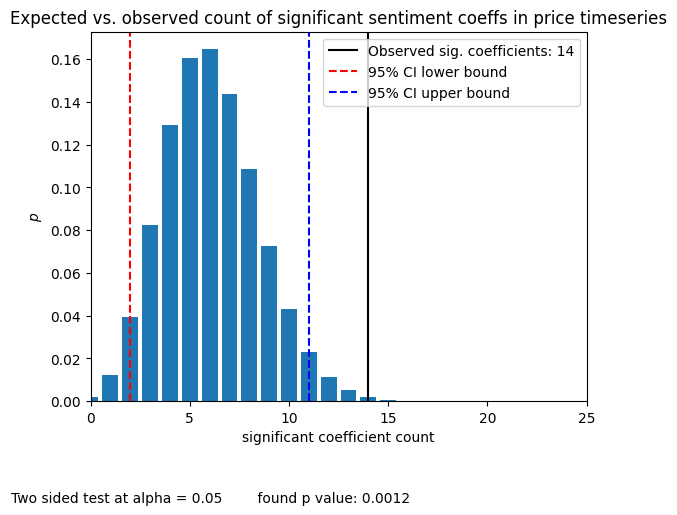

<Figure size 1500x1500 with 0 Axes>

In [66]:
n = sum_of_sentiment_lagged_coefficient_counts
p = 0.05
binom_data = [binom.pmf(r, n, p) for r in range(n+1) ]
plt.bar( range(n+1), binom_data)
plt.axvline(sum_of_significant_sentiment_coefficient_counts, color = 'black',label = f'Observed sig. coefficients: {str(sum_of_significant_sentiment_coefficient_counts)}')
plt.title("Expected vs. observed count of significant sentiment coeffs in price timeseries")
CI_95_two_sided = [binom.ppf(0.025, 122, 0.05), binom.ppf(0.975, 122, 0.05)]
plt.axvline(CI_95_two_sided[0], color = 'r',linestyle = 'dashed',label = '95% CI lower bound')
plt.axvline(CI_95_two_sided[1], color = 'b',linestyle = 'dashed',label = '95% CI upper bound')
plt.legend()
plt.xlabel(r'significant coefficient count')
plt.ylabel(r'$p$')
plt.xlim([0,25])
plt.figtext(x=0, y =-0.1, s= f'Two sided test at alpha = 0.05        found p value: {str(round(p_value,4))}')
plt.figure(figsize=(15,15))
plt.show()



Concluding, according to this two sided binomial test, given this sample and significance (alpha 0.05) and assumptions, H0 (proportion of significant sentiments coefficients in price timeseries = 0.05) is rejected in favor of H1 (proportion of significant sentiments coefficients in price timeseries != 0.05)'.

Next, to test if the influence of the price on sentiment is significant, by testing of the proportion of price coefficient in the sentiment timeseries is equal to 0.05,
we create the following sub-hypothesis for the nextbinomial test:

We thus create the following sub-hypotheses for the biomial test:

$\textbf{H0}: p = 0.05$ (the proportion of significant price coefficients in the sentiment timeseries is equal to 0.05)

$\textbf{H1}: p \neq 0.05$ (the proportion of significant price coefficients in the sentiment timeseries is NOT equal to 0.05)

In [67]:
sum_of_significant_prices_coefficient_counts = significant_coefficients_per_stock(results, 1).iloc[:,0].sum()
sum_of_prices_lagged_coefficient_counts = significant_coefficients_per_stock(results, 1).iloc[:,1].sum()
print('sum_of_significant_prices_coefficient_counts:', sum_of_significant_prices_coefficient_counts)
print('sum_of_prices_lagged_coefficient_counts:', sum_of_prices_lagged_coefficient_counts)

sum_of_significant_prices_coefficient_counts: 13
sum_of_prices_lagged_coefficient_counts: 122


In [68]:
p_value = 1 - binom.cdf(sum_of_significant_prices_coefficient_counts, sum_of_prices_lagged_coefficient_counts, 0.05)
print('Found p-value: ', round(p_value,4))
if round(p_value,4) < 0.05:
    print('p_value < 0.05(alpha), thus:')
    print('H0 (proportion of significant sentiments coefficients in price timeseries = 0.05) is rejected in favor of H1 (proportion of significant sentiments coefficients in price timeseries != 0.05)')
elif round(p_value,4) > 0.05:
    print('p_value > 0.05 (alpha), thus:')
    print('H0 (proportion of significant sentiments coefficients in price timeseries = 0.05) is NOT rejected')

Found p-value:  0.0032
p_value < 0.05(alpha), thus:
H0 (proportion of significant sentiments coefficients in price timeseries = 0.05) is rejected in favor of H1 (proportion of significant sentiments coefficients in price timeseries != 0.05)


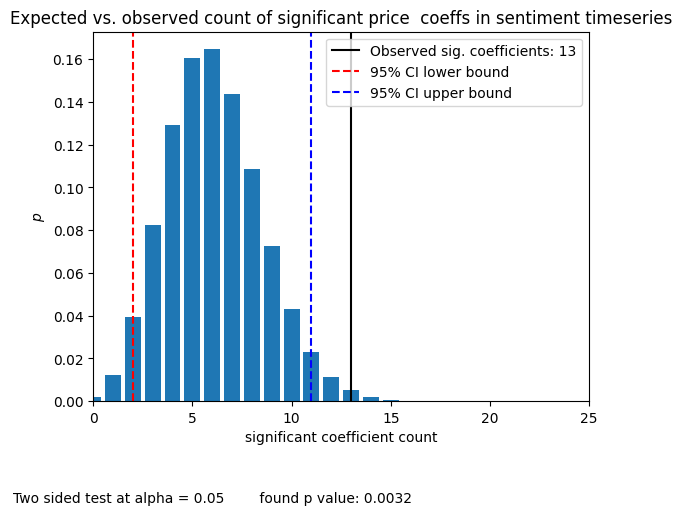

<Figure size 1500x1500 with 0 Axes>

In [69]:
n = sum_of_prices_lagged_coefficient_counts
p = 0.05
binom_data = [binom.pmf(r, n, p) for r in range(n+1) ]
plt.bar( range(n+1), binom_data)
plt.axvline(sum_of_significant_prices_coefficient_counts, color = 'black',label = f'Observed sig. coefficients: {str(sum_of_significant_prices_coefficient_counts)}')
plt.title("Expected vs. observed count of significant price  coeffs in sentiment timeseries")
CI_95_two_sided = [binom.ppf(0.025, 122, 0.05), binom.ppf(0.975, 122, 0.05)]
plt.axvline(CI_95_two_sided[0], color = 'r',linestyle = 'dashed',label = '95% CI lower bound')
plt.axvline(CI_95_two_sided[1], color = 'b',linestyle = 'dashed',label = '95% CI upper bound')
plt.legend()
plt.xlabel(r'significant coefficient count')
plt.ylabel(r'$p$')
plt.xlim([0,25])
plt.figtext(x=0, y =-0.1, s= f'Two sided test at alpha = 0.05        found p value: {str(round(p_value,4))}')
plt.figure(figsize=(15,15))
plt.show()

Concluding, according to this two sided binomial test, given this sample and significance (alpha 0.05) and assumptions, H0 (proportion of significant sentiment coefficients in price timeseries = 0.05) is rejected in favor of H1 (proportion of significant sentiments coefficients in price timeseries != 0.05).

As both of our sub hypotheses are rejected, we can conclude that there is a significant, bidirectiional relationship between the sentiment and the price of the stock, given this sample, assumtions and siginficance. Thus:

## Conclusion testing H0A:


H0 A: There is no relationship between sentiment about a stock in news articles and this stock's price movements. -> Rejected

at the 0.05 level, given this sample & assumptions, in favor of H1A: There is a relationship between sentiment about a stock in news articles and this stock's price movements.

In fact, the evidence indicates this relationship is bidirectional.